In [15]:
import numpy as np
import autoinv.numpy as anp
import autoinv.core as core
from autoinv.numpy.numpy_wrapper import primitive

import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc
%matplotlib inline

## Simple arithmetic example

In [16]:
def im_process(my_im):
    
    gamma = 2.2
    my_im = my_im ** gamma
    
    white_level = .25
    my_im = white_level * my_im
    
    return my_im

im_process_inv = core.make_inverse(im_process, anp.array([]))

In [17]:
im = anp.array(sp.misc.imread('tiger.jpg'))/255.
    
new_arr = im_process(im)
core.print_trace(new_arr.node)
print '\n'

y = im_process(im)
im_ = im_process_inv(y)

print '\n\t DIFF {} (should be small)'.format(anp.linalg.norm(im_-im))

<Node 1929 for fn multiply. Called with Nodes [1928] in positions [1]>
<Node 1928 for fn power. Called with Nodes [1927] in positions [0]>
<Node 1927 for fn divide. Called with Nodes [1926] in positions [0]>
<Node 1926 for fn array. Called with Nodes [] in positions []>



	 DIFF 1.9915604832e-14 (should be small)


## HDR+ merge example

In [18]:
def rcwindow(N):
    x = np.linspace(0., N, N, endpoint=False)
    rcw = .5 - .5 * np.cos(2.*np.pi * (x + .5) / N)
    rcw = rcw.reshape((N,1)) * rcw.reshape((1,N))
    return rcw

def hdrplus_merge(imgs, c, sig):
    # imgs is [..., h, w, ch]
    rcw = rcwindow(imgs.shape[-2])[...,np.newaxis]
    imgs = imgs * rcw
    imgs_f = np.fft.fft2(imgs, axes=(-3,-2))
    Dz2 = np.square(np.abs(imgs_f[...,0:1] - imgs_f))
    Az = Dz2 / (Dz2 + c*sig**2)
    filts = 1 - Az
    filts[...,0] = 1 + np.sum(Az[...,1:], axis=-1)
    output_f = np.mean(imgs_f * filts, axis=-1)
    output_f = np.real(np.fft.ifft2(output_f))
    
    return output_f

    
def hdrplus_tiled(noisy, c, sig, N):
    sh = noisy.shape[0:2]
    buffer = np.zeros_like(noisy[...,0])
    
    for i in range(2):
        for j in range(2):
    
            def patchify(noisy):
                # Apply offset
                patches = anp.roll(noisy, shift=anp.array([-N//2*i, -N//2*j]), axis=(0,1))
                # Reshape to isolate NxN tiles
                sh_ = [sh[0]//N, N, sh[1]//N, N] + list(patches.shape[2:])
                patches = anp.reshape(patches, sh_)
                patches = anp.swapaxes(patches, 2, 1)
                return patches
                
            depatchify = core.make_inverse(patchify, noisy[...,0])
            
            patches = patchify(noisy)
            merged_patches = hdrplus_merge(patches, c, sig)
            merged = depatchify(merged_patches)
            
            buffer += merged
            
    return buffer

Create stack of misaligned, noisy images

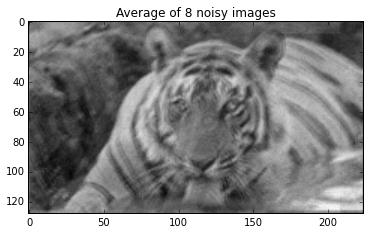

In [19]:
def down2(im):
    im = im[:im.shape[0]//2*2, :im.shape[1]//2*2, ...]
    im = anp.reshape(im, [im.shape[0]//2, 2, im.shape[1]//2, 2] + list(im.shape[2:]))
    return anp.mean(anp.mean(im, axis=3), axis=1)

im = anp.array(sp.misc.imread('tiger.jpg')) / 255.
im = down2(down2(im))
im = anp.mean(im, -1)
N = 16
im = im[:im.shape[0]//N*N, :im.shape[1]//N*N, ...]

T = 8
im_stack = anp.tile(anp.expand_dims(im, -1), T)
for t in range(T):
    if t > 0 and anp.random.uniform() < 2./T:
        xy = anp.array(anp.random.randint(-16, 16, size=[2]))
    else:
        xy = anp.array(anp.random.randint(-2, 2, size=[2]))
    im_ = im_stack[..., t]
    im_stack[..., t] = anp.roll(im_, xy, axis=[0,1])
    
sig = .05
noisy = im_stack + anp.random.normal(size=im_stack.shape) * sig
    
plt.imshow(anp.mean(noisy, axis=-1).view(np.ndarray), cmap='gray')
plt.title('Average of 8 noisy images')
plt.show()

Apply HDR+ merge

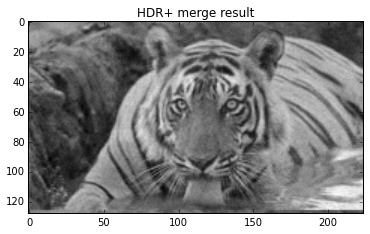

In [20]:
filtered = hdrplus_tiled(noisy, 10**2.5, sig, 16)

plt.imshow(filtered.view(np.ndarray), cmap='gray')
plt.title('HDR+ merge result')
plt.show()

## FFT example

In [21]:
def gen_box_filt(M, W):
    box = anp.zeros([M])
    box[M//2-W:M//2+W] = 1.
    box = box / anp.sum(box)
    box = anp.roll(box, M//2)
    return box

def twiddle(x):
    # Define the twiddle factors matrix
    N = x.shape[-1] + 0.
    omega = anp.exp(-2.j * anp.pi / (2*N) * anp.arange(0, N))
    a0 = anp.stack([anp.ones_like(omega),  omega], axis=-1)
    a1 = anp.stack([anp.ones_like(omega), -omega], axis=-1)
    a = anp.stack([a0, a1], axis=-2)

    # Merge 'even' and 'odd' halves with twiddle matrix
    x = anp.swapaxes(x, -1, -2)
    x = anp.expand_dims(x, -1)
    x = anp.matmul(a, x)
    x = anp.swapaxes(x, -2, -3)
    x = anp.reshape(x, list(x.shape[:-3]) + [-1])
    return x

# Cooley-Tukey 1D FFT over the last axis of x
def my_fft(x):
    if x.shape[-1] >= 2:
        # Separate 'even' and 'odd' halves of last axis
        x = anp.reshape(x, list(x.shape[:-1]) + [x.shape[-1]//2, 2])
        x = anp.swapaxes(x, -1, -2)
        # Recursively apply FFT to each half
        x = my_fft(x)
        # Use twiddle to merge the halves
        x = twiddle(x)
    return x

# 2D FFT on final two axes as two applications of 1D FFT
def my_fft2(x):
    x1 = my_fft(x)
    x2 = my_fft(anp.swapaxes(x1, -1, -2))
    x2 = anp.swapaxes(x2, -1, -2)
    return x2


	 FFT error 9.07459280821e-14

	 Inverse error 2.09271565073e-15

	 FFT2 error 1.13644884682e-11

	 FFT2 Inv error 2.34884348773e-14


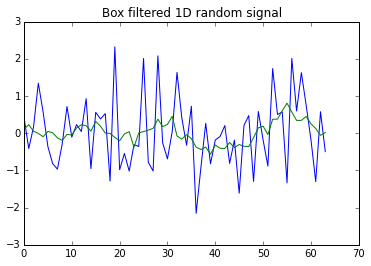

In [22]:

M = 64
my_fft_inv = core.make_inverse(my_fft, anp.zeros([M]))
my_fft2_inv = core.make_inverse(my_fft2, anp.zeros([M,M]))
    
x = anp.random.normal(size=[M])
y = my_fft(x)

x_ = my_fft_inv(y)
xf_ = my_fft_inv(y * my_fft(gen_box_filt(M, W=4)))

print '\n\t FFT error', np.linalg.norm(y - np.fft.fft(x))
print '\n\t Inverse error', np.linalg.norm(x - x_)

X = anp.random.normal(size=[M,M])
print '\n\t FFT2 error', np.linalg.norm(my_fft2(X) - np.fft.fft2(X))
err = np.linalg.norm(core.make_inverse(my_fft2, anp.zeros([M,M]))(my_fft2(X)) - X)
print '\n\t FFT2 Inv error', err


plt.plot(anp.real(x).view(np.ndarray))
plt.plot(anp.real(xf_).view(np.ndarray))
plt.title('Box filtered 1D random signal')
plt.show()

## Camera projection example

In [24]:
def rodrigues(r):
    theta = np.linalg.norm(r)
    k = r / theta
    K = np.array([[0, -k[2], k[1]], [k[2], 0, -k[0]], [-k[2], k[0], 0.]])
    R = np.eye(3) + np.sin(theta) * K + (1. - np.cos(theta)) * np.dot(K, K)
    return R

# pts.shape is [..., 2]
def pix2cam(ppoint, f):
    def fun(pts):
        pts = pts - ppoint
        pts = pts / f
        pts = anp.concatenate([pts, -anp.ones(list(pts.shape[:-1]) + [1])], axis=-1)
        return pts
    return fun

# pts.shape is [..., 3]
def cam2world(rvec, tvec):
    R = rodrigues(rvec)
    def fun(pts):
        pts = anp.expand_dims(pts, -1)
        pts = anp.matmul(R, pts)
        pts = anp.squeeze(pts, -1)
        pts = pts + tvec
        return pts
    return fun

def reproject_pts(depths):
    def fun(pts):
        return pts * depths
    return fun

@primitive 
def project_pts(pts):
    return pts / anp.expand_dims(-pts[..., 2], -1)

def pix2world(ppoint, f, rvec, tvec, depths):
    reproj_fn = primitive(reproject_pts(depths))
    core.definv(reproj_fn, (lambda ans, g : lambda g : project_pts(g)))
    def fun(pts):
        return cam2world(rvec, tvec)(reproj_fn(pix2cam(ppoint, f)(pts)))
    return fun
    
def pix2pix(ppoint, f, rt0, rt1):
    def ret_fn(pts, depths):
        p2w_0 = pix2world(ppoint, f, rt0[:,0], rt0[:,1], depths)
        p2w_1 = pix2world(ppoint, f, rt1[:,0], rt1[:,1], anp.zeros_like(depths))
        w2p_1 = core.make_inverse(p2w_1, pts)
        return w2p_1(p2w_0(pts))
    return ret_fn

In [25]:
w = 480.
h = 320.
f = 380.
ppoint = anp.array([h, w]) * .5

rt0 = anp.random.normal(size=[3,2])
rt1 = anp.random.normal(size=[3,2])

N = 32
    
depths = 1. + np.abs(np.random.normal(size=[N, 1]))
pts = anp.array(anp.random.uniform(size=[N, 2]) * anp.array([h, w]))

# This fn should be identity
p2p_00 = pix2pix(ppoint, f, rt0, rt0)
pts_ = p2p_00(pts, depths)
print '\n\tShould be zero (projecting from cam0 to cam0): ', np.linalg.norm(pts-pts_)

# This fn will project points from camera 0 into camera 1
p2p_01 = pix2pix(ppoint, f, rt0, rt1) 


	Should be zero (projecting from cam0 to cam0):  4.99127824065e-13
